In [65]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage import img_as_float
from skimage.filters import frangi

#ocena skuteczności
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
import numpy as np
from scipy.stats import gmean
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay

ZADANIE NA 3

In [66]:
#Wybór pliku

#nazwa_pliku = '01_g'
threshold = 0.03

In [ ]:
def load_image(nazwa_pliku):
    img = cv2.imread('all/images/'+ nazwa_pliku +'.jpg')

    #zostawiamy tylko kanał zielony
    green_channel = img[:, :, 1]
    image = green_channel

    return image, img

In [ ]:
def show_rgb(img):
    green_channel = img[:, :, 1]
    red_channel = img[:, :, 2]
    blue_channel = img[:, :, 0]

    #wyświetlamy wszystkie kanały obok siebie
    plt.figure(figsize=(15,5))

    plt.subplot(1, 3, 1)
    plt.imshow(red_channel, cmap='gray')
    plt.title('Czerwony kanał')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(green_channel, cmap='gray')
    plt.title('Zielony kanał')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(blue_channel, cmap='gray')
    plt.title('Niebieski kanał')
    plt.axis('off')

    plt.show()

In [ ]:
def load_mask(nazwa_pliku):
    #wczytywanie maski
    mask = cv2.imread('all/mask/'+ nazwa_pliku +'_mask.tif', cv2.IMREAD_GRAYSCALE)

    #konwersja wartości
    mask_norm = (mask > 127).astype(int)

    #print(mask_norm[1000][100:200])

    return mask_norm

In [ ]:
def give_result(nazwa_pliku):
    image, img = load_image(nazwa_pliku)
    mask_norm = load_mask( nazwa_pliku )

    #ograniczenie wartości pikseli 
    image = np.clip(image, 10, 245)

    #zastosowanie CLAHE (poprawa kontrastu)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    image_clahe = clahe.apply(image)

    #konwersja do float w zakresie 0-1 (wymagane przez frangi)
    image_float = img_as_float(image_clahe)

    #zastosowanie filtra Frangi
    frangi_result = frangi(image_float, sigmas=np.arange(2, 20, 1), black_ridges=True)

    #normalizacja wyniku filtra Frangi
    frangi_norm = frangi_result / frangi_result.max()

    #ustawienie progu (wartość dobrana eksperymentalnie)
    threshold = 0.03
    binary_mask = np.where(frangi_norm > threshold, 1, 0)

    result = binary_mask & mask_norm
    
    return result, image_clahe, binary_mask, img

In [ ]:
def calculate_correct_output(nazwa_pliku):
    #wczytywanie poprawnego rozwiązania
    correct_output = cv2.imread('all/manual1/'+ nazwa_pliku +'.tif', cv2.IMREAD_GRAYSCALE)

    correct_output_norm = (correct_output > 127).astype(int)

    return correct_output, correct_output_norm

Macierz pomyłek

| Przypadek | Interpretacja |
|-----------|---------------|
| **TP**    | piksel poprawnie oznaczony jako "naczynie" |
| **TN**    | piksel poprawnie oznaczony jako "tło" |
| **FP**    | piksel błędnie oznaczony jako "naczynie", a to było tło |
| **FN**    | piksel błędnie oznaczony jako "tło", a to było naczynie |

- Dokładność: (TP + TN) / N - jaki procent pikseli został poprawnie oznaczony jako naczynie lub tło
- Czułość: TP / (TP + FN) jaki procent rzeczywistych naczyń (klasy pozytywnej) został poprawnie wykryty
- Swoistość:  TN / (TN + FP)  jaki procent rzeczywistego tła został poprawnie rozpoznany jako tło


In [ ]:
def show_parameters(nazwa_pliku):
    _, correct_output_norm = calculate_correct_output(nazwa_pliku)
    result, _, _, _ = give_result(nazwa_pliku)

    #macierz pomyłek
    y_true = correct_output_norm.flatten()
    y_pred = result.flatten()
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()


    # sprawdzenie czy suma parametrów się zgadza TP+TN+FP+FN=N
    #print(tn+ fp+ fn+ tp == 2336* 3504)

    # Trafność (accuracy)
    accuracy = accuracy_score(y_true, y_pred)

    # Czułość (sensitivity, recall)
    sensitivity = recall_score(y_true, y_pred, pos_label=1)  # TP / (TP + FN)

    # Swoistość (specificity)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Średnie metryki 
    mean_arithmetic = (sensitivity + specificity) / 2
    mean_geometric = gmean([sensitivity, specificity]) if sensitivity > 0 and specificity > 0 else 0

    return accuracy, sensitivity, specificity, mean_arithmetic, mean_geometric, cm


Przetwarzam: 01_g...
Przetwarzam: 02_g...
Przetwarzam: 03_g...
Przetwarzam: 04_g...
Przetwarzam: 05_g...


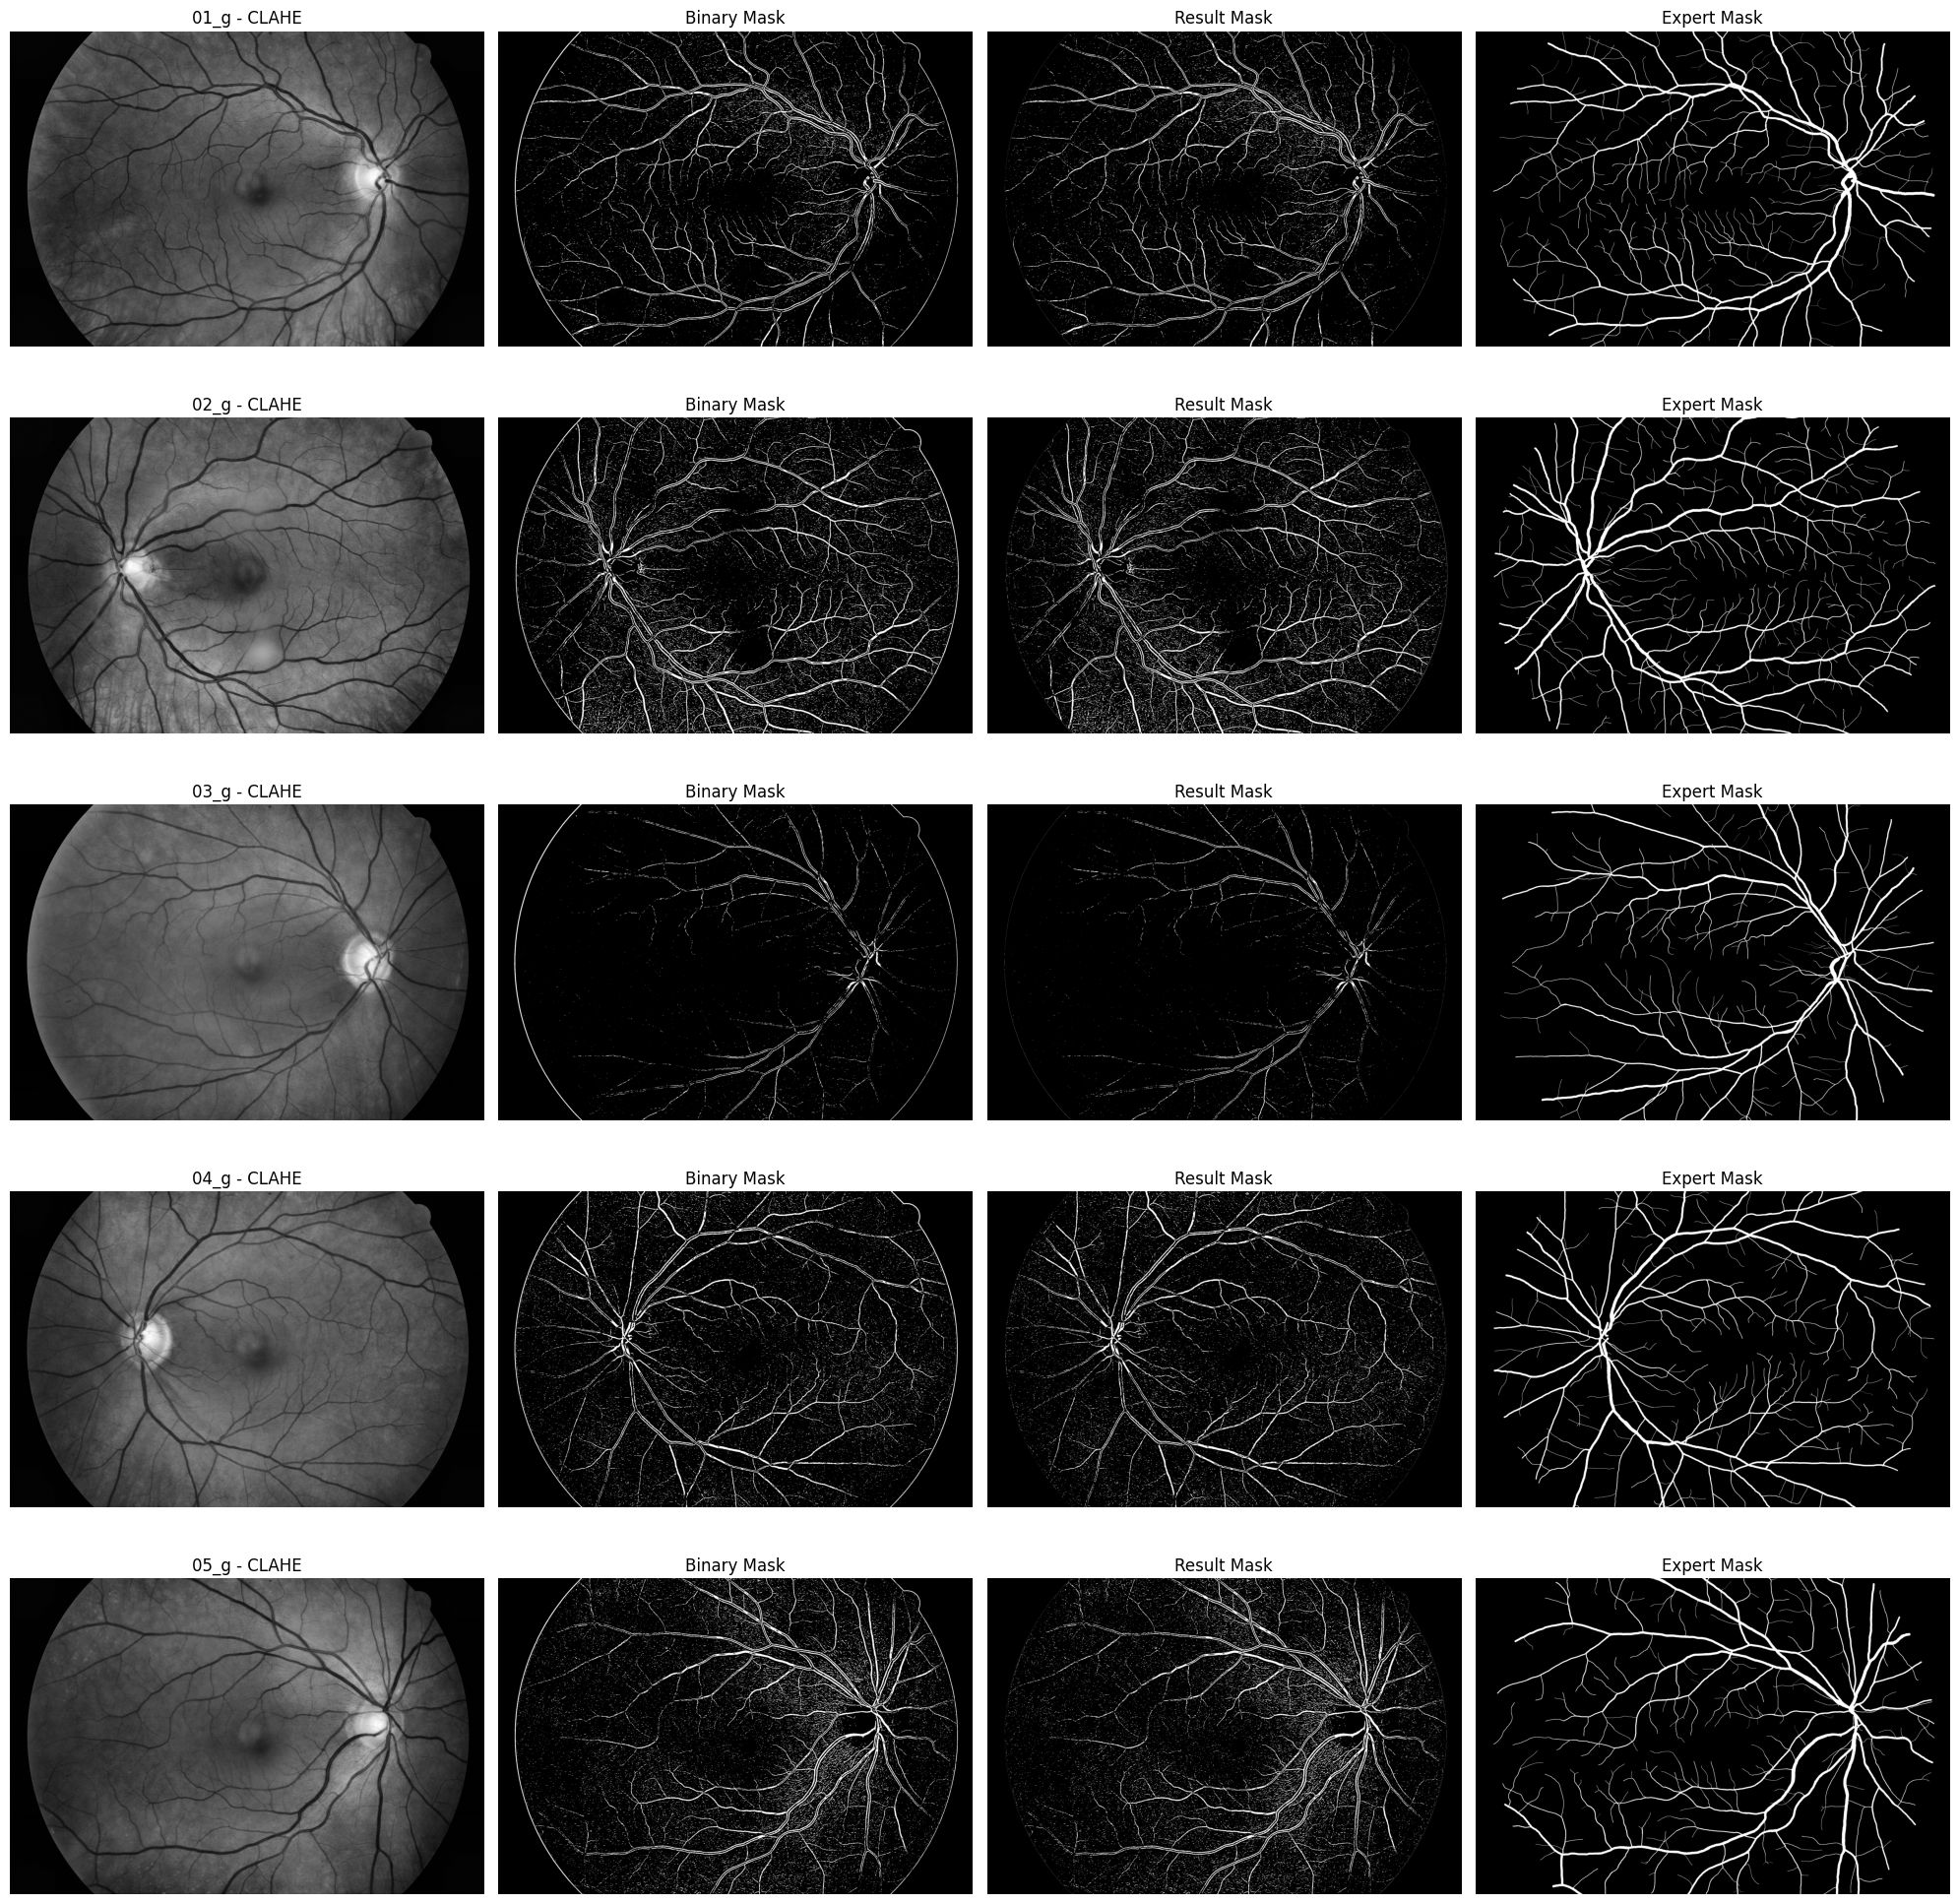

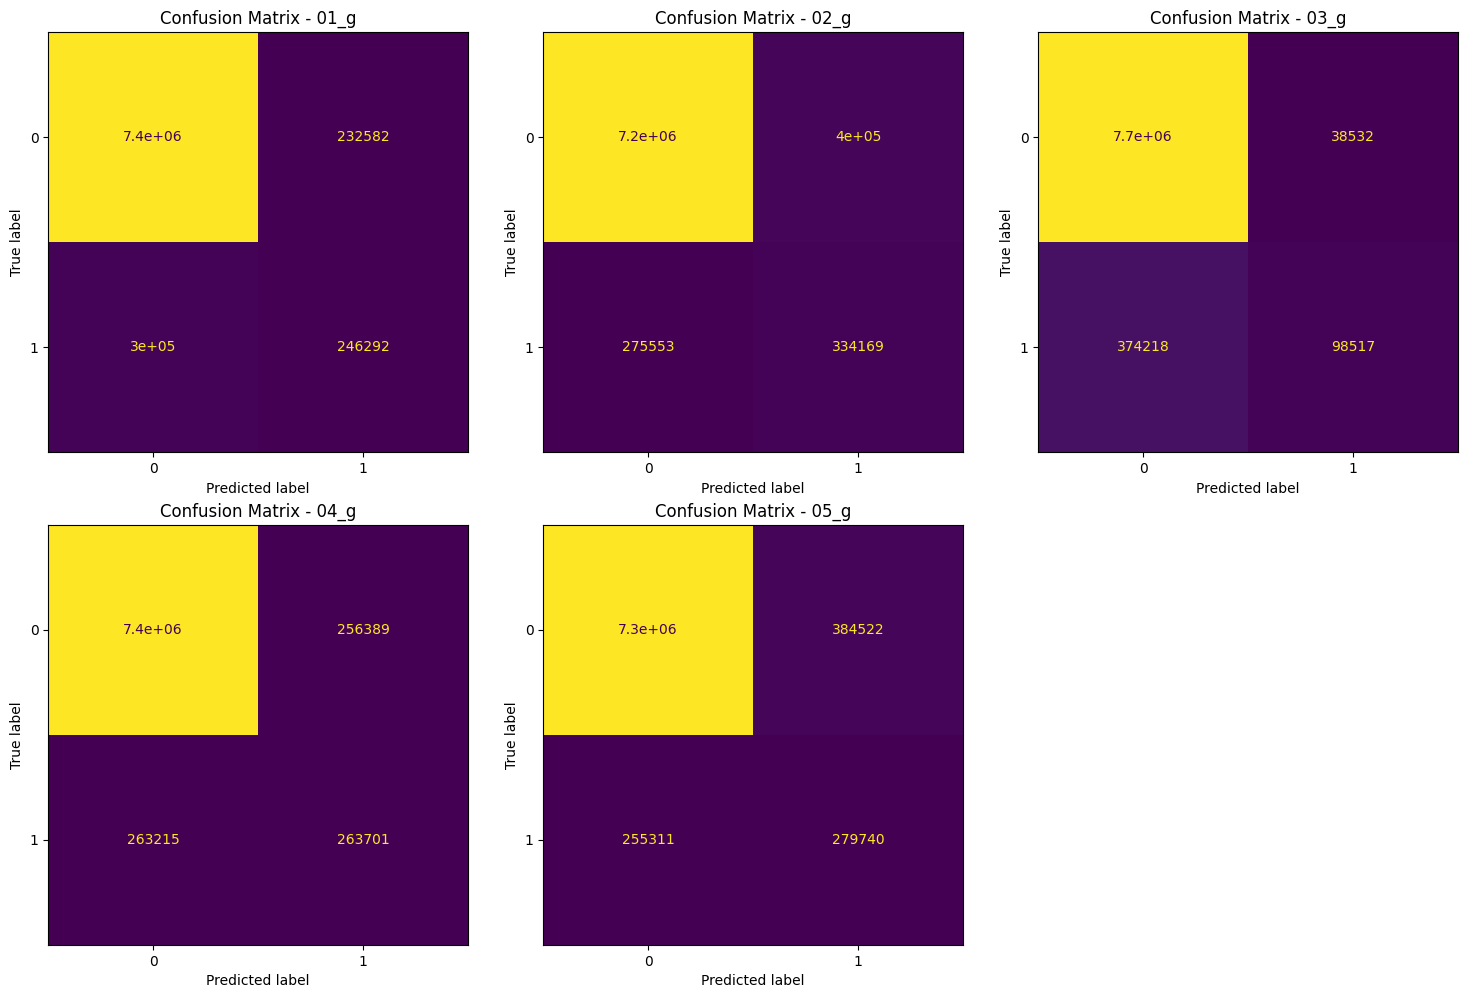

,Plik,Accuracy,Sensitivity,Specificity,Mean (arith),Mean (geom)
0,01_g,0.9348,0.4497,0.9695,0.7096,0.6603
1,02_g,0.9173,0.5481,0.9470,0.7475,0.7204
2,03_g,0.9496,0.2084,0.9950,0.6017,0.4554
3,04_g,0.9365,0.5005,0.9665,0.7335,0.6955
4,05_g,0.9218,0.5228,0.9497,0.7363,0.7047


In [ ]:

nazwy_plikow = ['01_g', '02_g', '03_g', '04_g', '05_g']

#listy do przechowywania wyników
clahe_list = []
binary_list = []
result_list = []
expert_list = []
metrics_list = []
conf_matrices = []

for nazwa_pliku in nazwy_plikow:
    print(f"Przetwarzam: {nazwa_pliku}...")

    # --- 1. Obliczenia ---
    correct_output, _ = calculate_correct_output(nazwa_pliku)
    result, image_clahe, binary_mask, img = give_result(nazwa_pliku)
    accuracy, sensitivity, specificity, mean_arithmetic, mean_geometric, cm = show_parameters(nazwa_pliku)

    # --- 2. Dodajemy wartości do list ---
    clahe_list.append(image_clahe)
    binary_list.append(binary_mask)
    result_list.append(result)
    expert_list.append(correct_output)

    metrics_list.append({
        'Plik': nazwa_pliku,
        'Accuracy': accuracy,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Mean (arith)': mean_arithmetic,
        'Mean (geom)': mean_geometric
    })

    conf_matrices.append((nazwa_pliku, cm))

# --- 3. Wyświetlamy wyniki ---
fig, axs = plt.subplots(len(nazwy_plikow), 4, figsize=(20, 4 * len(nazwy_plikow)))

for i in range(len(nazwy_plikow)):
    axs[i, 0].imshow(clahe_list[i], cmap='gray')
    axs[i, 0].set_title(f'{nazwy_plikow[i]} - CLAHE')
    axs[i, 0].axis('off')

    axs[i, 1].imshow(binary_list[i], cmap='gray')
    axs[i, 1].set_title('Binary Mask')
    axs[i, 1].axis('off')

    axs[i, 2].imshow(result_list[i], cmap='gray')
    axs[i, 2].set_title('Result Mask')
    axs[i, 2].axis('off')

    axs[i, 3].imshow(expert_list[i], cmap='gray')
    axs[i, 3].set_title('Expert Mask')
    axs[i, 3].axis('off')

plt.tight_layout()
plt.show()

# --- 4. Rysujemy macierze pomyłek ---
n = len(conf_matrices)
cols = 3
rows = (n + cols - 1) // cols
fig, axs = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))

for idx, (file_name, cm) in enumerate(conf_matrices):
    r, c = divmod(idx, cols)
    ax = axs[r, c] if rows > 1 else axs[c]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, colorbar=False)
    ax.set_title(f"Confusion Matrix - {file_name}")

for idx in range(n, rows * cols):
    r, c = divmod(idx, cols)
    ax = axs[r, c] if rows > 1 else axs[c]
    ax.axis('off')

plt.tight_layout()
plt.show()

# --- 5. Wyświetlamy metryki w tabeli ---
metrics_df = pd.DataFrame(metrics_list)

display(metrics_df.style
        .format({
            "Accuracy": "{:.4f}",
            "Sensitivity": "{:.4f}",
            "Specificity": "{:.4f}",
            "Mean (arith)": "{:.4f}",
            "Mean (geom)": "{:.4f}"
        })
        .set_properties(**{'text-align': 'left'})
        .set_table_styles([dict(selector='th', props=[('text-align', 'left')])])
        )
